<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/deep_q_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Q-Network implementation
包括三个组成部分：

- approximate q-learning
- experience replay
- target networks 

In [1]:
import os
os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


### 目标: 训练一个玩atari的agent
游戏数据信息：
- atari 游戏画面图像默认大小是210x160x3

为了节省时间，可以对图像进行resize操作，变成64x64的黑白图像。并且去除顶部和底部无用的图像区域。

In [0]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)
        print("self.observation_space={0}".format(self.observation_space.shape))

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        # crop image
        img=img[20:,:,:]
        # resize
        img = Image.fromarray(img.astype(np.uint8))
        img = img.resize(self.img_size)
        # 灰度
        img = img.convert('L')

        #归一化：
        imgdata=np.array(img.getdata(),dtype='float32')
        min_val = np.min(imgdata)
        max_val = np.max(imgdata)
        imgdata = (imgdata-min_val)/max_val
        imgdata = imgdata.reshape((1, *self.img_size))
        #print("imgdata[0,:]".format(imgdata[0,:]))
        print("imgdata shape={0}".format(imgdata.shape))
        return imgdata

In [80]:
import gym
env = gym.make("BreakoutDeterministic-v0")
observation_shape = env.observation_space.shape
print("observation_shape={0}".format(observation_shape))
env = PreprocessAtari(env)
observation_shape = env.observation_space.shape
print("observation_shape={0}".format(observation_shape))
n_actions = env.action_space.n
obs = env.reset()


observation_shape=(210, 160, 3)
self.observation_space=(64, 64)
observation_shape=(64, 64)
imgdata shape=(1, 64, 64)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(1, 64, 64)
(64, 64)
float32
Formal tests seem fine. Here's an example of what you'll get.


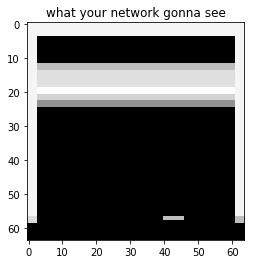

In [82]:
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
print(obs.shape)
print(observation_shape)
#assert obs.shape == observation_shape
print(obs.dtype)
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to (0,1) range"
print ("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[0], interpolation='none', cmap='gray')


### Frame Buffer

单张图片训练时无法反应图片的速度和运动反向。所以这个实验采用连续四张图片进行训练

In [0]:
import numpy as np
from gym.spaces.box import Box
from gym.core import Wrapper


class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

In [87]:

#包括图片预处理和frame buffer功能的env
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env


env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

self.observation_space=(64, 64)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


ValueError: ignored